In [136]:
seed = 1024
import numpy as np
np.random.seed(seed)

In [137]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.image import imread


In [138]:
STDir = "/projects/li-lab/Yue/DataPool/Spatial/ST-Net/data/hist2tscript"
resultDir = '/projects/li-lab/Yue/SpatialAnalysis/output'

import sys
sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py') ##~wont work, has to start with /Users
import ensembl #from st-net

In [139]:
def read_st_net_data(
    i
) -> sc.AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names for a feature barcode matrix, probe names for a probe bc matrix
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.obs`\\ `[filtered_barcodes]`
        filtered barcodes if present in the matrix
    :attr:`~anndata.AnnData.var`
        Any additional metadata present in /matrix/features is read in.
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    
    STDir = "/projects/li-lab/Yue/DataPool/Spatial/ST-Net/data/hist2tscript"
    
    df_meta = pd.read_csv(STDir+'/metadata.csv')
    library_id = df_meta.patient[i]+'_'+df_meta.replicate[i]
    print(library_id)
    print(df_meta.iloc[i])
    

    # read json scalefactors
    #adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
    #    files['scalefactors_json_file'].read_bytes()
    #)

    #adata.uns["spatial"][library_id]["metadata"] = {
    #    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #    for k in ("chemistry_description", "software_version")
    #    if k in attrs
    #}

    # read coordinates
    
    coords_csv = STDir+ '/' + df_meta.spot_coordinates[i]
    positions = pd.read_csv(coords_csv, index_col = 0)
    #print(positions)
    
    coords_csv = STDir+ '/' + df_meta.tumor_annotation[i]
    spot_df = pd.read_csv(coords_csv, index_col = False, sep = '\t')
    spot_df.columns = ['id','xcoord', 'ycoord', 'lab', 'tumor']

    spot_df['id'] = spot_df.xcoord.astype('str') + 'x' + spot_df.ycoord.astype('str')
    spot_df.index = spot_df['id']
    #print(spot_df)
    


    st_csv = STDir+ '/' + df_meta.count_matrix[i]
    st_exp_df = pd.read_csv(st_csv, index_col = 0, sep = '\t')
    #print(st_exp_df)
    #adata.obs = positions
    positions = positions.join(spot_df, how="left")
    positions['in_tissue'] = 1

    positions.columns = [
        'pxl_row_in_fullres',
        'pxl_col_in_fullres',
        'id',
        'array_row',
        'array_col',
        'lab',
        'tumor',
        'in_tissue',
        
        
    ]
    
    st_exp_df = st_exp_df.reindex(list(positions.index))
    #positions = positions.reindex(list(st_exp_df.index))
    
    
    gene_names = list(map(lambda x: ensembl.symbol[x], st_exp_df.columns))
    st_exp_df.columns = gene_names
    
    var_df = pd.DataFrame(st_exp_df.columns)
    var_df.index = st_exp_df.columns
    
    print(positions.head())
    print(var_df.head())
    print(st_exp_df.head())
    
    adata = sc.AnnData(X = st_exp_df,
                       obs = positions,
                       var = var_df)
    adata.uns["spatial"] = dict()

    adata.uns["spatial"][library_id] = dict()

    tissue_positions_file = STDir + '/' + df_meta.spot_coordinates[i]

    # check if files exists, continue if images are missing

    adata.uns["spatial"][library_id]['images'] = dict()
    for res in ['hires']:
        try:
            adata.uns["spatial"][library_id]['images'][res] = imread(
                str(STDir+ '/' + df_meta.histology_image[i])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    
    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
#     adata.obs.drop(
#         columns=['pxl_row_in_fullres', 'pxl_col_in_fullres'],
#         inplace=True,
#     )

    # put image path in uns
#     if source_image_path is not None:
#         # get an absolute path
#         source_image_path = str(Path(source_image_path).resolve())
#         adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
#             source_image_path
#         )

    return adata

In [140]:
#HE_BT23903_C2.jpg  HE_BT23450_E1.jpg
df_meta = pd.read_csv(STDir+'/metadata.csv')
#idx = df_meta.histology_image[df_meta.histology_image == 'HE_BT23903_C2.jpg'].index[0]

#patient_id = 'BC23903'
#patient_id = 'BC23450'
patient_id = 'BC23287'


rep_id = 'C1' #C1 C2
idx = df_meta.loc[(df_meta.patient == patient_id) & (df_meta.replicate == rep_id),:].index[0]


library_id = patient_id + '_' + rep_id
df_prediction = pd.read_csv('pretrained_ViT_cv_prediction.csv',index_col = 0)
#df_prediction = pd.read_csv('scratch_ViT_cv_prediction.csv',index_col = 0)

df_index = pd.Series(df_prediction.index).str.split('_', expand = True)
df_index.columns = ['patient','rep','coords']
df_index.index = df_prediction.index
df_prediction_sub = df_prediction.loc[(df_index.patient == patient_id) & (df_index.rep == rep_id),:]
df_prediction_sub.index = df_index.loc[df_prediction_sub.index,:].coords

In [141]:
df_prediction

,RPS3,IGLL5,RPLP1,TFF3,TMSB10,RPS18,GAPDH,RPLP2,RPL37A,RPS14,...,COX4I1,PFDN5,SPARC,ISG15,EIF5A,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472],FXYD3,UBE2M,COL6A2,CHCHD2
BC23209_C1_3x21,2.062522,2.274657,2.842162,1.187566,2.662145,2.622372,2.632204,2.668511,2.408814,2.540340,...,0.845686,0.965369,0.937453,0.762935,0.824928,0.720153,0.811344,0.843668,1.014394,0.807160
BC23209_C1_12x20,1.768138,1.934129,2.566688,0.976563,2.298852,2.336301,2.290283,2.385177,2.111347,2.264787,...,0.665471,0.838176,0.805259,0.602903,0.651542,0.522707,0.636163,0.658385,0.935462,0.630985
BC23209_C1_5x19,2.271520,2.544707,3.014832,1.348295,2.894584,2.813072,2.871415,2.853445,2.611366,2.731189,...,0.983141,1.048007,1.001340,0.878562,0.967695,0.882054,0.926810,0.991329,1.027601,0.939237
BC23209_C1_6x13,2.065521,2.278759,2.849176,1.195151,2.670927,2.630605,2.638264,2.682567,2.415136,2.549741,...,0.847903,0.969501,0.950888,0.766254,0.826655,0.720045,0.813897,0.848432,1.025962,0.810000
BC23209_C1_6x24,2.263592,2.530789,3.023217,1.335992,2.894770,2.813317,2.868857,2.856628,2.608024,2.732282,...,0.973982,1.045008,1.005824,0.870546,0.955063,0.867036,0.919798,0.981170,1.038826,0.930588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC24105_C1_26x22,2.326582,2.365524,2.902099,1.328523,2.706175,2.752273,2.771850,2.739434,2.632567,2.572030,...,0.986372,0.956958,0.846073,0.853484,1.008501,1.019639,0.882667,1.031574,0.810021,1.007488
BC24105_C1_26x23,2.394181,1.858869,2.856796,1.138600,2.468095,2.719614,2.689855,2.631581,2.732804,2.369947,...,0.960149,0.798688,0.772569,0.692933,1.019400,1.191234,0.709520,0.966725,0.702716,1.119666
BC24105_C1_8x28,2.121711,1.156165,2.551018,0.720144,2.057019,2.400075,2.362237,2.306545,2.517608,1.936967,...,0.792095,0.566741,0.750401,0.485151,0.840030,1.096229,0.458778,0.728201,0.691799,1.082010
BC24105_C1_8x25,2.093934,1.142654,2.528459,0.693217,2.039178,2.386953,2.348109,2.286099,2.499608,1.910037,...,0.784582,0.562033,0.760417,0.479520,0.826916,1.077081,0.445903,0.714179,0.712358,1.075286


In [142]:
df_prediction_sub.columns = df_prediction_sub.columns + '_pred'
#df_prediction_sub = (df_prediction_sub - df_prediction_sub.mean())/df_prediction_sub.std()
df_prediction_sub

,RPS3_pred,IGLL5_pred,RPLP1_pred,TFF3_pred,TMSB10_pred,RPS18_pred,GAPDH_pred,RPLP2_pred,RPL37A_pred,RPS14_pred,...,COX4I1_pred,PFDN5_pred,SPARC_pred,ISG15_pred,EIF5A_pred,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred,FXYD3_pred,UBE2M_pred,COL6A2_pred,CHCHD2_pred
coords,,,,,,,,,,,,,,,,,,,,,
14x27,1.562463,1.749543,2.266875,0.791383,1.985027,2.036138,1.993803,2.093659,1.835381,1.936243,...,0.573617,0.704608,0.666867,0.511133,0.546406,0.451006,0.508101,0.554513,0.801407,0.543335
15x31,1.562206,1.749330,2.266568,0.791222,1.984636,2.035830,1.993496,2.093349,1.835083,1.935889,...,0.573536,0.704489,0.666638,0.511008,0.546291,0.450943,0.507920,0.554398,0.801161,0.543207
13x27,1.564759,1.752389,2.269798,0.792731,1.988158,2.038978,1.996639,2.096567,1.838002,1.939032,...,0.574589,0.705578,0.668073,0.512207,0.547504,0.451850,0.509273,0.555667,0.802541,0.544219
17x33,1.564862,1.752583,2.270227,0.792818,1.988531,2.039323,1.996883,2.096994,1.838256,1.939456,...,0.574466,0.705752,0.668312,0.512188,0.547389,0.451596,0.509349,0.555644,0.802939,0.544066
16x19,1.565619,1.753453,2.271402,0.793318,1.989596,2.040315,1.997789,2.098006,1.839089,1.940379,...,0.574771,0.706116,0.668772,0.512561,0.547703,0.451815,0.509712,0.556012,0.803363,0.544284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10x22,2.441491,2.734280,3.087521,1.323938,2.950594,2.913807,3.000238,2.926513,2.730029,2.754501,...,1.081627,1.023866,0.957296,0.945579,1.067332,1.055357,0.950559,1.083118,0.913023,1.053327
12x23,2.512000,2.628339,3.105894,1.254749,2.853987,2.918780,3.006620,2.918440,2.820913,2.704530,...,1.088971,0.922429,0.892748,0.875074,1.097862,1.195238,0.861456,1.079919,0.799702,1.142897
5x27,2.488373,2.426580,3.051566,1.139320,2.708975,2.849824,2.939087,2.827004,2.815354,2.588231,...,1.041074,0.815371,0.871091,0.779152,1.068234,1.233747,0.756457,1.013466,0.749543,1.174040


In [143]:
gene_predict = 'DDX5'
#gene_predict = 'ACTG1'
#gene_predict = 'GNAS'

adata = read_st_net_data(idx)
sc.pp.scale(adata)

BC23287_C1
type                            HER2_luminal
patient                              BC23287
replicate                                 C1
count_matrix        BC23287_C1_stdata.tsv.gz
histology_image            HE_BT23287_C1.jpg
spot_coordinates     spots_BT23287_C1.csv.gz
tumor_annotation    BC23287_C1_Coords.tsv.gz
Name: 0, dtype: object
       pxl_row_in_fullres  pxl_col_in_fullres     id  array_row  array_col  \
11x17            2885.544            4621.855  11x17         11         17   
16x17            4339.348            4621.039  16x17         16         17   
10x17            2608.214            4623.132  10x17         10         17   
14x17            3778.747            4623.339  14x17         14         17   
15x17            4058.496            4627.485  15x17         15         17   

      lab  tumor  in_tissue  
11x17  L1  tumor          1  
16x17  L2    non          1  
10x17  L3  tumor          1  
14x17  L4    non          1  
15x17  L5    non          1  
  

/tmp/ipykernel_4740/399338450.py:125: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = st_exp_df,
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (91769216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [144]:
gene_predict in list(df_prediction.columns)

True

In [145]:
# plt.hist(np.log(adata.X[:,adata.var.index == gene_predict]+1))
#adata.X[:,adata.var.index == gene_predict]
# #plt.hist(df_prediction_sub[gp])
# d = df_prediction_sub[gp]
# d = np.exp(d)
# d = (d - d.mean())/d.std()
# print(np.mean(d))
# print(np.var(d))
# plt.hist(d)
# print(np.var(adata.obs[gp]))

In [146]:
#############prediction
gp = gene_predict+'_pred'

df_prediction_sub[gp] = np.exp(df_prediction_sub[gp]) ###exp since prediction is log(x+1)
#adata.obs[gp].fillna(0, inplace = True)

df_prediction_sub[gp] = (df_prediction_sub[gp] - df_prediction_sub[gp].mean())/df_prediction_sub[gp].std()

print(np.mean(df_prediction_sub[gp]))
print(np.var(df_prediction_sub[gp]))
adata.obs = adata.obs.join(df_prediction_sub[gp])
#adata.obs[gp].fillna(0, inplace = True)


2.220446049250313e-16
0.9960937499999999


/tmp/ipykernel_4740/4087237561.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_sub[gp] = np.exp(df_prediction_sub[gp]) ###exp since prediction is log(x+1)
/tmp/ipykernel_4740/4087237561.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_sub[gp] = (df_prediction_sub[gp] - df_prediction_sub[gp].mean())/df_prediction_sub[gp].std()


In [147]:
img_shape = adata.uns["spatial"][library_id]['images']['hires'].shape

0.6227692794079067


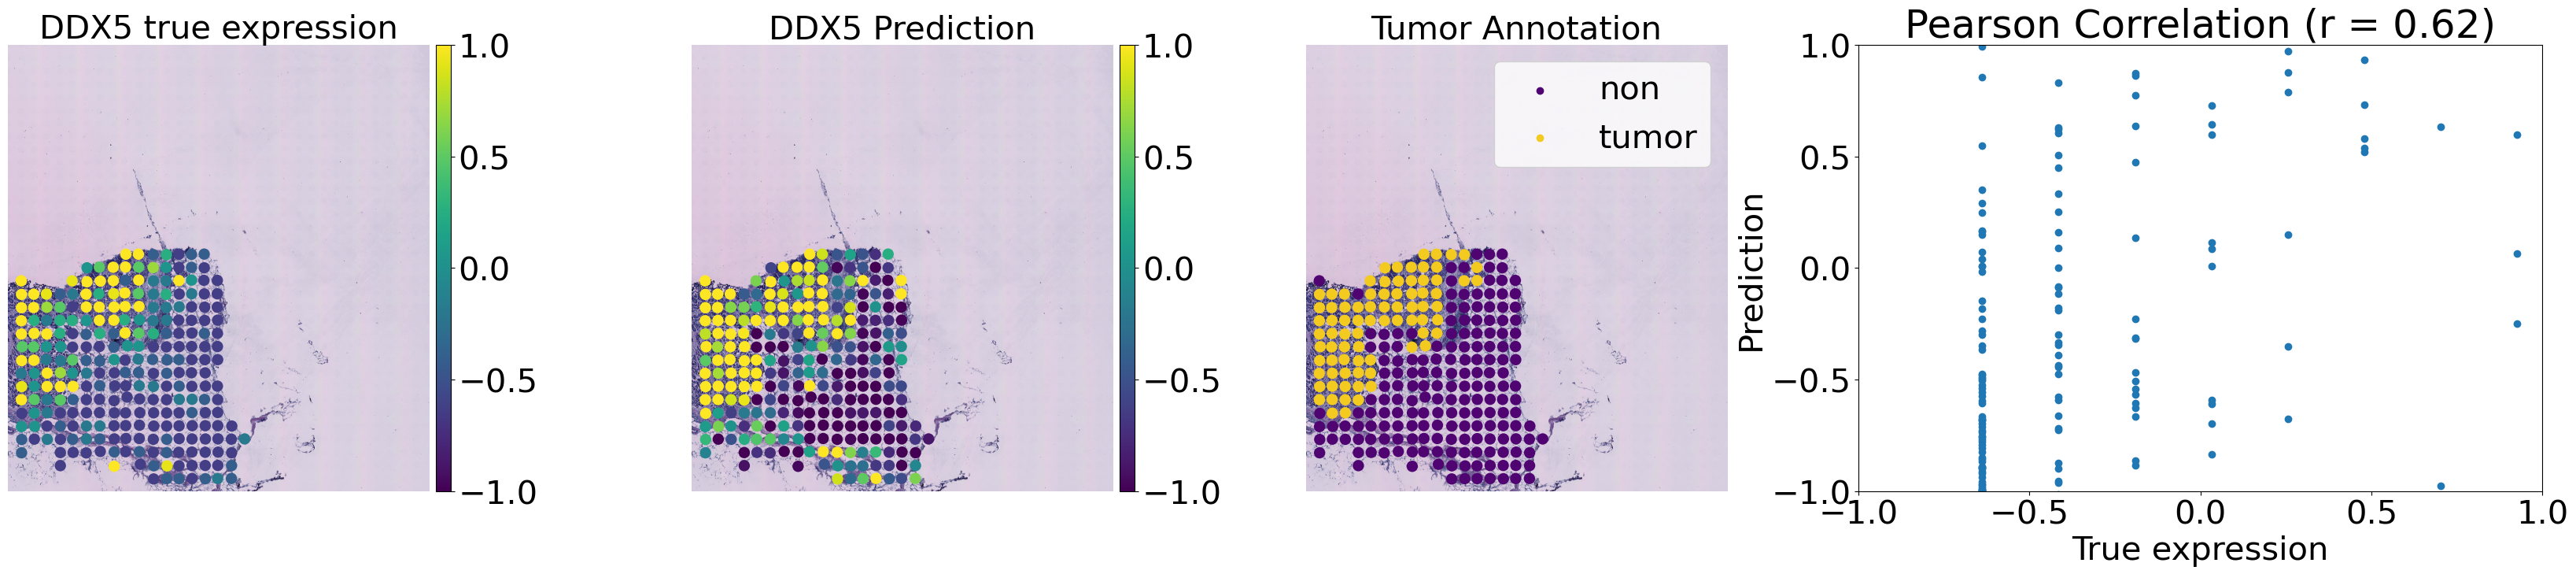

In [148]:
fig, axs = plt.subplots(ncols=4, figsize=(36, 8))
font_size = 30
plt.rcParams.update({'font.size': font_size})


#plt.title('Tumor', fontsize = font_size)
sc.pl.spatial(adata, img_key = "hires", color='tumor',
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              na_in_legend = False,
              #return_fig = True,
              ax = axs[2],
              title = 'Tumor',
              palette = ('#500472', '#f3ca20'),
              #save = 'pretrained_'+ library_id + '_tumor.pdf',
              legend_fontsize = font_size,
              show = False,
              #legend_loc = 'on data'
              #alpha = 0.8
              #vmin = ,vmax = 2
             )

#fig, ax = plt.subplots()

ax = sc.pl.spatial(adata, img_key = "hires", color=gp,
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              title = gene_predict+' Prediction',
              vmin = -1,vmax = 1,
              na_in_legend = False,
              return_fig = True,
              ax = axs[1],
              show = False,
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf',
              #colorbar_loc = 'bottom'
             )


#fig, ax = plt.subplots()


sc.pl.spatial(adata, img_key = "hires", color=gene_predict,
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              vmin = -1, vmax = 1,
              na_in_legend = False,
              return_fig = True,
              ax = axs[0],
              show = False,
              title = gene_predict+' true expression',
              #colorbar_loc = 'bottom'
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf'
   
             )
ax4 = axs[3]
x = np.array(adata.X[:,adata.var.index == gene_predict])

x = (x - x.mean())/x.std()
x = x.flatten()

y = np.array(adata.obs[gp]).flatten()

xy = np.vstack([x.flatten(), y.flatten()])
#density = np.log(np.histogram2d(xy[0], xy[1], bins=50, density=True)[0])
#pcm = ax4.imshow(density, cmap='plasma', origin='lower', aspect='1', extent=[x.min(), x.max(), y.min(), y.max()])
#pcm = ax4.hist2d(x, y, bins=(50, 50), cmap=plt.cm.Greys)
ax4.plot(x,y, linestyle='none', marker='o')
ax4.set_xlim(-1,1)
ax4.set_ylim(-1,1)
#plt.colorbar(pcm, label='Density', pad=0.04, fraction=0.046, cax = ax4)  # Add a colorbar and adjust its position
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(x.flatten(), y.flatten())[0, 1]
print(correlation_coefficient)
# plt.text(0.02, 0.93, f'r = {correlation_coefficient:.2f}',
#          transform=plt.gca().transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
ax4.set_xlabel("True expression", fontsize = font_size)
ax4.set_ylabel("Prediction",fontsize = font_size)
ax4.set_title(f"Pearson Correlation (r = {correlation_coefficient:.2f})")

    

titles = [
            gene_predict+' true expression',
            gene_predict+' Prediction',
            'Tumor Annotation',
            'Tumor Annotation vs Prediction'
         ]
for i in range(4):
    if i == 3:
        continue
    else:
        fig.axes[i].set_axis_off()
        
    fig.axes[i].set_title(titles[i], fontdict={'fontsize': font_size, 'fontweight': 'medium'})
    

    
fig.axes[-2].tick_params(labelsize=font_size) 
fig.axes[-1].tick_params(labelsize=font_size) 
fig.axes[2].legend(loc= 'upper right')

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig(resultDir+'/pretrained_'+ library_id + '_'+gene_predict+ '_aggregate'+'.pdf',
            bbox_inches='tight')

In [149]:
plt.show()

In [150]:
adata.X[:,adata.var.index == gene_predict]

array([[ 2.7093244 ],
       [-0.41393667],
       [ 1.8169641 ],
       [-0.6370268 ],
       [-0.41393667],
       [-0.41393667],
       [ 0.25533357],
       [ 0.47842366],
       [ 1.8169641 ],
       [ 0.47842366],
       [-0.41393667],
       [ 2.7093244 ],
       [ 0.7015137 ],
       [ 0.03224349],
       [-0.6370268 ],
       [-0.6370268 ],
       [ 0.03224349],
       [ 4.047865  ],
       [ 0.03224349],
       [-0.6370268 ],
       [-0.6370268 ],
       [-0.41393667],
       [ 1.3707839 ],
       [ 3.824775  ],
       [ 2.4862344 ],
       [-0.19084659],
       [-0.19084659],
       [ 0.9246038 ],
       [ 2.0400543 ],
       [ 1.3707839 ],
       [ 1.5938741 ],
       [ 0.47842366],
       [ 0.9246038 ],
       [ 0.25533357],
       [-0.19084659],
       [-0.19084659],
       [-0.6370268 ],
       [-0.41393667],
       [-0.6370268 ],
       [ 4.940225  ],
       [ 0.9246038 ],
       [ 1.8169641 ],
       [-0.19084659],
       [-0.6370268 ],
       [ 0.25533357],
       [ 1

In [151]:
adata.obs[gp]

11x17    0.850790
16x17    0.250327
10x17    1.982993
14x17   -0.490580
15x17   -0.718788
           ...   
17x34   -0.543807
13x34   -0.334729
14x34    0.504620
12x34    0.856836
16x34   -0.441816
Name: DDX5_pred, Length: 256, dtype: float64

In [152]:
df_prediction_sub[gp]

coords
14x27   -1.124849
15x31   -1.125011
13x27   -1.122567
17x33   -1.123447
16x19   -1.123108
           ...   
10x22    1.198310
12x23    1.813465
5x27     1.866655
6x26     1.885644
3x23     1.779104
Name: DDX5_pred, Length: 256, dtype: float64

In [153]:
adata.obs['is_tumor'] = 0
adata.obs['is_tumor'].loc[adata.obs['tumor'] == 'tumor'] = 1
adata.obs[gp] = adata.obs[gp].fillna(0)
np.corrcoef(adata.obs[gp],adata.obs['is_tumor'])


/tmp/ipykernel_4740/4182595116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['is_tumor'].loc[adata.obs['tumor'] == 'tumor'] = 1


array([[1.        , 0.73396495],
       [0.73396495, 1.        ]])

In [154]:
np.corrcoef(adata.obs['is_tumor'], adata.X[:,adata.var.index == gene_predict].flatten())


array([[1.        , 0.66603189],
       [0.66603189, 1.        ]])

In [155]:
np.corrcoef(adata.obs[gp],adata.X[:,adata.var.index == gene_predict].flatten())


array([[1.        , 0.62276928],
       [0.62276928, 1.        ]])

In [156]:
# fig, axs = plt.subplots(1,4, figsize=(15,4))
# fig.suptitle('Covariates for filtering')
# sb.distplot(adata.obs['total_counts'], kde=False, ax = axs[0])
# sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<10000], kde=False, bins=40, ax = axs[1])
# #sb.distplot(adata.obs['min_counts'], kde=False, ax = axs[0])

# sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
# sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<10000], kde=False, bins=60, ax = axs[3])

In [157]:
adata.X[:,adata.var.index == gene_predict]

array([[ 2.7093244 ],
       [-0.41393667],
       [ 1.8169641 ],
       [-0.6370268 ],
       [-0.41393667],
       [-0.41393667],
       [ 0.25533357],
       [ 0.47842366],
       [ 1.8169641 ],
       [ 0.47842366],
       [-0.41393667],
       [ 2.7093244 ],
       [ 0.7015137 ],
       [ 0.03224349],
       [-0.6370268 ],
       [-0.6370268 ],
       [ 0.03224349],
       [ 4.047865  ],
       [ 0.03224349],
       [-0.6370268 ],
       [-0.6370268 ],
       [-0.41393667],
       [ 1.3707839 ],
       [ 3.824775  ],
       [ 2.4862344 ],
       [-0.19084659],
       [-0.19084659],
       [ 0.9246038 ],
       [ 2.0400543 ],
       [ 1.3707839 ],
       [ 1.5938741 ],
       [ 0.47842366],
       [ 0.9246038 ],
       [ 0.25533357],
       [-0.19084659],
       [-0.19084659],
       [-0.6370268 ],
       [-0.41393667],
       [-0.6370268 ],
       [ 4.940225  ],
       [ 0.9246038 ],
       [ 1.8169641 ],
       [-0.19084659],
       [-0.6370268 ],
       [ 0.25533357],
       [ 1

In [158]:
adata.obs

,pxl_row_in_fullres,pxl_col_in_fullres,id,array_row,array_col,lab,tumor,in_tissue,DDX5_pred,is_tumor
11x17,2885.544,4621.855,11x17,11,17,L1,tumor,1,0.850790,1
16x17,4339.348,4621.039,16x17,16,17,L2,non,1,0.250327,0
10x17,2608.214,4623.132,10x17,10,17,L3,tumor,1,1.982993,1
14x17,3778.747,4623.339,14x17,14,17,L4,non,1,-0.490580,0
15x17,4058.496,4627.485,15x17,15,17,L5,non,1,-0.718788,0
...,...,...,...,...,...,...,...,...,...,...
17x34,4636.713,9578.601,17x34,17,34,L252,non,1,-0.543807,0
13x34,3513.946,9580.398,13x34,13,34,L253,non,1,-0.334729,0
14x34,3785.362,9579.845,14x34,14,34,L254,non,1,0.504620,0
12x34,3222.614,9587.609,12x34,12,34,L255,non,1,0.856836,0


In [159]:
adata.var

,0,mean,std
TSPAN6,TSPAN6,0.144531,0.592940
TNMD,TNMD,0.003906,0.062500
DPM1,DPM1,0.148438,0.444396
SCYL3,SCYL3,0.031250,0.174333
C1orf112,C1orf112,0.031250,0.174333
...,...,...,...
__ambiguous[ENSG00000281593+ENSG00000180233],__ambiguous[ENSG00000281593+ENSG00000180233],0.000000,1.000000
__ambiguous[ENSG00000281887+ENSG00000196329],__ambiguous[ENSG00000281887+ENSG00000196329],0.019531,0.138654
__ambiguous[ENSG00000281991+ENSG00000282034],__ambiguous[ENSG00000281991+ENSG00000282034],0.199219,0.556036
__ambiguous[ENSG00000282246+ENSG00000165630],__ambiguous[ENSG00000282246+ENSG00000165630],0.007812,0.088215


# Tumor predictor vs ViT

In [160]:
adata = read_st_net_data(idx)

tumor_mean = adata.X[adata.obs.tumor == 'tumor',:].mean(axis = 0)
normal_mean = adata.X[adata.obs.tumor == 'non',:].mean(axis = 0)

corr_naive = []
corr_vit = []

df_prediction_sub = df_prediction.loc[(df_index.patient == patient_id) & (df_index.rep == rep_id),:]
df_prediction_sub.index = df_index.loc[df_prediction_sub.index,:].coords
df_prediction_sub.columns = df_prediction_sub.columns + '_pred_vit' 
###exp since prediction is log(x+1)
#adata.obs[gp].fillna(0, inplace = True)
#df_prediction_sub = (df_prediction_sub - df_prediction_sub.mean())/df_prediction_sub.std()

adata.obs = adata.obs.join(df_prediction_sub)
adata.obs.fillna(0, inplace=True)

for i in range(250):
    g = df_prediction.columns[i]
    adata.obs[g+'_pred_naive'] = 0
    adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
    adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'non'] = normal_mean[adata.var.index == g][0]
    
    cor = np.corrcoef(adata.obs[g+'_pred_naive'][df_prediction_sub.index],adata[df_prediction_sub.index,:].X[:,adata.var.index == g].flatten())[0,1]
    corr_naive.append(cor)
    
    cor = np.corrcoef(df_prediction_sub[g+'_pred_vit'],adata[df_prediction_sub.index,:].X[:,adata.var.index == g].flatten())[0,1]
    corr_vit.append(cor)
    


BC23287_C1
type                            HER2_luminal
patient                              BC23287
replicate                                 C1
count_matrix        BC23287_C1_stdata.tsv.gz
histology_image            HE_BT23287_C1.jpg
spot_coordinates     spots_BT23287_C1.csv.gz
tumor_annotation    BC23287_C1_Coords.tsv.gz
Name: 0, dtype: object
       pxl_row_in_fullres  pxl_col_in_fullres     id  array_row  array_col  \
11x17            2885.544            4621.855  11x17         11         17   
16x17            4339.348            4621.039  16x17         16         17   
10x17            2608.214            4623.132  10x17         10         17   
14x17            3778.747            4623.339  14x17         14         17   
15x17            4058.496            4627.485  15x17         15         17   

      lab  tumor  in_tissue  
11x17  L1  tumor          1  
16x17  L2    non          1  
10x17  L3  tumor          1  
14x17  L4    non          1  
15x17  L5    non          1  
  

/tmp/ipykernel_4740/399338450.py:125: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = st_exp_df,
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (91769216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/tmp/ipykernel_4740/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_4740/82192976.py:22: SettingWithCopyWarning: 
A val

(array([ 9., 11., 13., 15., 46., 51., 58., 31., 10.,  6.]),
 array([0.01684006, 0.09120991, 0.16557976, 0.23994961, 0.31431946,
        0.38868932, 0.46305917, 0.53742902, 0.61179887, 0.68616872,
        0.76053857]),
 <BarContainer object of 10 artists>)

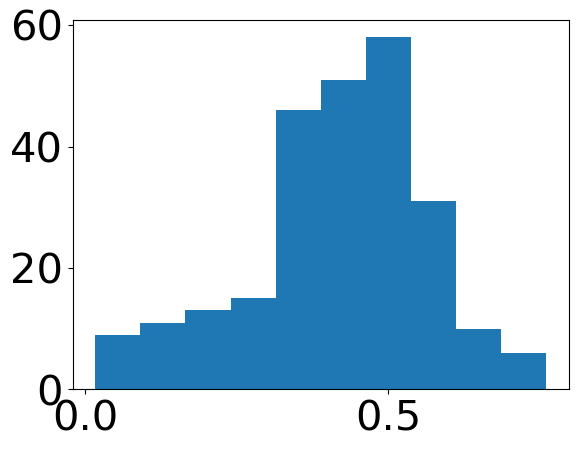

In [161]:
plt.hist(corr_naive)


In [162]:
adata.obs.loc[df_prediction_sub.index,:]

,pxl_row_in_fullres,pxl_col_in_fullres,id,array_row,array_col,lab,tumor,in_tissue,RPS3_pred_vit,IGLL5_pred_vit,...,COX4I1_pred_naive,PFDN5_pred_naive,SPARC_pred_naive,ISG15_pred_naive,EIF5A_pred_naive,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred_naive,FXYD3_pred_naive,UBE2M_pred_naive,COL6A2_pred_naive,CHCHD2_pred_naive
coords,,,,,,,,,,,,,,,,,,,,,
14x27,3786.225,7538.028,14x27,14,27,L152,non,1,1.562463,1.749543,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
15x31,4070.880,8704.091,15x31,15,31,L217,non,1,1.562206,1.749330,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
13x27,3509.067,7539.063,13x27,13,27,L146,non,1,1.564759,1.752389,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
17x33,4640.546,9288.854,17x33,17,33,L241,non,1,1.564862,1.752583,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
16x19,4333.726,5200.513,16x19,16,19,L20,non,1,1.565619,1.753453,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10x22,2577.448,6073.643,10x22,10,22,L64,tumor,1,2.441491,2.734280,...,2.037500,1.800000,4.1875,0.237500,2.875,3.400000,3.450000,2.262500,1.712500,3.875000
12x23,3217.751,6378.871,12x23,12,23,L86,non,1,2.512000,2.628339,...,0.835227,0.653409,1.3125,0.119318,0.750,0.630682,0.840909,0.840909,0.818182,0.880682
5x27,1159.880,7546.236,5x27,5,27,L157,tumor,1,2.488373,2.426580,...,2.037500,1.800000,4.1875,0.237500,2.875,3.400000,3.450000,2.262500,1.712500,3.875000


In [163]:
df_prediction_sub

,RPS3_pred_vit,IGLL5_pred_vit,RPLP1_pred_vit,TFF3_pred_vit,TMSB10_pred_vit,RPS18_pred_vit,GAPDH_pred_vit,RPLP2_pred_vit,RPL37A_pred_vit,RPS14_pred_vit,...,COX4I1_pred_vit,PFDN5_pred_vit,SPARC_pred_vit,ISG15_pred_vit,EIF5A_pred_vit,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred_vit,FXYD3_pred_vit,UBE2M_pred_vit,COL6A2_pred_vit,CHCHD2_pred_vit
coords,,,,,,,,,,,,,,,,,,,,,
14x27,1.562463,1.749543,2.266875,0.791383,1.985027,2.036138,1.993803,2.093659,1.835381,1.936243,...,0.573617,0.704608,0.666867,0.511133,0.546406,0.451006,0.508101,0.554513,0.801407,0.543335
15x31,1.562206,1.749330,2.266568,0.791222,1.984636,2.035830,1.993496,2.093349,1.835083,1.935889,...,0.573536,0.704489,0.666638,0.511008,0.546291,0.450943,0.507920,0.554398,0.801161,0.543207
13x27,1.564759,1.752389,2.269798,0.792731,1.988158,2.038978,1.996639,2.096567,1.838002,1.939032,...,0.574589,0.705578,0.668073,0.512207,0.547504,0.451850,0.509273,0.555667,0.802541,0.544219
17x33,1.564862,1.752583,2.270227,0.792818,1.988531,2.039323,1.996883,2.096994,1.838256,1.939456,...,0.574466,0.705752,0.668312,0.512188,0.547389,0.451596,0.509349,0.555644,0.802939,0.544066
16x19,1.565619,1.753453,2.271402,0.793318,1.989596,2.040315,1.997789,2.098006,1.839089,1.940379,...,0.574771,0.706116,0.668772,0.512561,0.547703,0.451815,0.509712,0.556012,0.803363,0.544284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10x22,2.441491,2.734280,3.087521,1.323938,2.950594,2.913807,3.000238,2.926513,2.730029,2.754501,...,1.081627,1.023866,0.957296,0.945579,1.067332,1.055357,0.950559,1.083118,0.913023,1.053327
12x23,2.512000,2.628339,3.105894,1.254749,2.853987,2.918780,3.006620,2.918440,2.820913,2.704530,...,1.088971,0.922429,0.892748,0.875074,1.097862,1.195238,0.861456,1.079919,0.799702,1.142897
5x27,2.488373,2.426580,3.051566,1.139320,2.708975,2.849824,2.939087,2.827004,2.815354,2.588231,...,1.041074,0.815371,0.871091,0.779152,1.068234,1.233747,0.756457,1.013466,0.749543,1.174040


(array([ 2.,  3.,  5., 13., 19., 51., 57., 60., 31.,  9.]),
 array([-0.09590838, -0.02336659,  0.04917519,  0.12171697,  0.19425875,
         0.26680054,  0.33934232,  0.4118841 ,  0.48442588,  0.55696767,
         0.62950945]),
 <BarContainer object of 10 artists>)

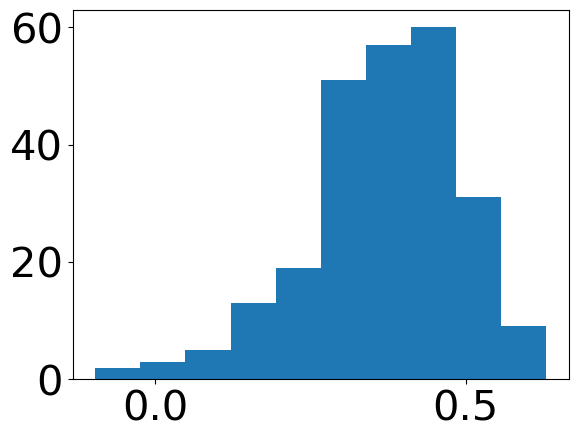

In [164]:
plt.hist(corr_vit)

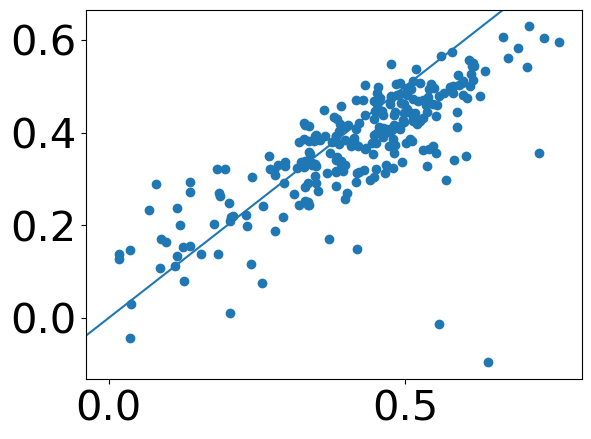

In [165]:
plt.scatter(corr_naive, corr_vit)
plt.axline((0, 0), slope=1)

In [166]:
# sc.pp.filter_cells(adata, min_counts = 5000)
# print(f'Number of cells after min count filter: {adata.n_obs}')
# sc.pp.filter_cells(adata, max_counts = 130000)
# print(f'Number of cells after max count filter: {adata.n_obs}')
# sc.pp.filter_cells(adata, min_genes = 3000)
# print(f'Number of cells after gene filter: {adata.n_obs}')
# sc.pp.filter_genes(adata, min_cells=10)
# print(f'Number of genes after cell filter: {adata.n_vars}')

In [167]:
# sc.pp.normalize_total(adata, inplace = True)
# #sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, inplace=True)

In [168]:
# sc.pp.pca(adata, n_comps=500, use_highly_variable=True, svd_solver='arpack')
# sc.pp.neighbors(adata)

# sc.tl.umap(adata)
# sc.tl.louvain(adata, key_added='clusters', resolution = 1)

In [169]:
# umap_coords = pd.DataFrame(adata.obsm['X_umap'])
# umap_coords.index = adata.obs.clusters.index
# umap_coords

# #umap_coords.to_csv(ResultsDir+'/umap_coords_C1D1.csv')

In [170]:
# sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts'])
# sc.pl.umap(adata, color='clusters', palette=sc.pl.palettes.default_20)


In [171]:
# adata.obs['clusters'] = adata.obs.clusters[adata.obs.index.map(str)].values #otherwise index not match, na
# sc.pl.spatial(adata, img_key = "hires", color="clusters", size=1, spot_size = 200, scale_factor = 1, crop_coord=[0, 9000, 0, 9000])



In [172]:
#plt.imshow(adata.uns["spatial"]['BC23287_C1']['images']['hires'])


In [173]:
# adata.X

In [174]:
#adata.obs.clusters.to_csv(ResultsDir+'/umap_cluster_C1D1_c'+str(num_clust)+'.csv')

In [175]:
#sc.pl.spatial(adata, img_key = "hires",color=['total_counts', 'n_genes_by_counts'])


In [176]:
#sc.pl.spatial(adata, img_key = "hires", color="clusters", groups = ["4","5"], crop_coord = [5000,8000,10000,15000], alpha = .5, size = 1.3)


In [177]:
# markers = pd.read_csv('markers_PDAC.csv', header=None).iloc[:,0]
# markers = markers[markers.isin(adata.var.index)]
# sub_adata = adata[:,markers]
# #sub_adata.X = (sub_adata.X - sub_adata.X.mean())/sub_adata.X.std()
# #
# #sc.pp.log1p(sub_adata)
# #sc.pp.scale(sub_adata)

# sc.tl.rank_genes_groups(sub_adata, "clusters", inplace = True)
# sc.pl.rank_genes_groups_heatmap(sub_adata, groupby = "clusters", show = True,
#                                 standard_scale = 'var',
#                                 var_names = markers, dendrogram =False, show_gene_labels=True)



In [178]:
# sub_adata.X

In [179]:
plt.subplots_adjust??

In [180]:
sc.pl.spatial??